<a href="https://colab.research.google.com/github/arushi118/Canny-Edge-Algorithm/blob/main/CANNY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **EDGE DETECTION**


---
The human eye has the incredible ability to process an image in a couple of milliseconds, and to determine what it is about.

The idea today is to build an algorithm that can 
sketch the edges of any object present on a picture, using the Canny edge detection algorithm.

Edge detection is a technique for finding the boundaries of objects in an image. It works by detecting sharp discontinuities in brightness.

## Part 1 -  Explaining Canny Algorithm

Importing some important libraries

In [7]:
# All the imports
from __future__ import print_function
 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from time import time
from skimage import io
 
%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 15.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
 
# for auto-reloading extenrnal modules
%load_ext autoreload
%autoreload 2 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# !wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1I95ZEbzwLYjPTGH5A_h5q3mLJcOB9e6U' -O edge.zip && unzip edge.zip

## Part 1: Basic Operations in Canny Edge Detector
1. Smoothing
2. Finding gradients
3. Non-maximum suppression
4. Double thresholding
5. Edge tracking by hysterisis

### 1.1 Smoothing 
#### Implementation 
An edge is something which shows a sharp change in colour. So we compare adjacent pixel values, to detect an edge and blur the image accordingly.

We first smooth the input image by convolving it with a Gaussian kernel. Gaussian Kernel is usually used to blur an image. The equation for a Gaussian kernel of size $(2k+1)\times(2k+1)$ is given by:

$$h_{ij}=\frac{1}{2\pi\sigma^2}\exp{\Bigl(-\frac{(i-k)^2+(j-k)^2}{2\sigma^2}\Bigr)}, 0\leq i,j < 2k+1$$

Here i is the coordinate of a particular pixel in the y direction, and j is the coordinate of that particular pixel in x direction.

σ controls the amount of blurring of the picture.


In [3]:
def gaussian_kernel(size, sigma):

    kernel = np.zeros((size, size))
    
    # code starts here
    a=1/(2*np.pi*(sigma**2))
    for i in range(0,size):
        for j in range(0,size):
            kernel[i][j]=a*np.exp(-((i-size//2)**2 + (j-size//2)**2 )/(2*sigma*sigma))

    #code ends here

    return kernel

### Define Convolution
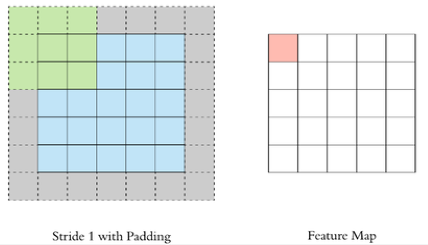
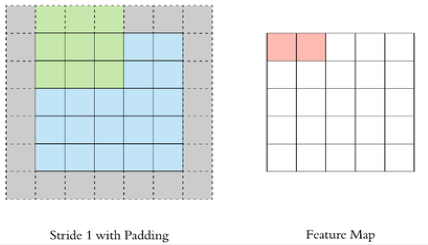

In [4]:
from scipy.signal import convolve2d
def conv(image, kernel):
    Hi, Wi = image.shape
    Hk, Wk = kernel.shape
    out = np.zeros((Hi, Wi))
  
    pad_width0 = Hk // 2
    pad_width1 = Wk // 2
    pad_width = ((pad_width0,pad_width0),(pad_width1,pad_width1))
    padded = np.pad(image, pad_width, mode='edge')

    # code start here
    out = convolve2d(padded, kernel, mode='valid')
    #code ends here
    
    return out

You can change the value of σ to see how different values of σ give different amount of blurring.

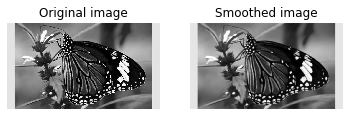

In [6]:
# Test with different kernel_size and sigma (This is it being interactive)
kernel_size = 5
sigma = 1.4

# Load image
img = io.imread('butterfly.jpeg', as_gray=True)
# Define 5x5 Gaussian kernel with std = sigma
kernel = gaussian_kernel(kernel_size, sigma)
# Convolve image with kernel to achieve smoothed effect
smoothed = conv(img, kernel)

plt.subplot(1,2,1)
plt.imshow(img)
plt.title('Original image')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(smoothed)
plt.title('Smoothed image')
plt.axis('off')

plt.show()

### 1.2 Finding gradients
The gradient of a 2D scalar function $I:\mathbb{R}^2\rightarrow{\mathbb{R}}$ in Cartesian coordinate is defined by:

$$\nabla{I(x,y)}=\bigl[\frac{\partial{I}}{\partial{x}},\frac{\partial{I}}{\partial{y}}\bigr],$$

where

$$
\frac{\partial{I(x,y)}}{\partial{x}}=\lim_{\Delta{x}\to{0}}\frac{I(x+\Delta{x},y)-I(x,y)}{\Delta{x}} \\
\frac{\partial{I(x,y)}}{\partial{y}}=\lim_{\Delta{y}\to{0}}\frac{I(x,y+\Delta{y})-I(x,y)}{\Delta{y}}.
$$

𝚫x = 1, as the smallest part of an image is a pixel, and the minimum distance you can move across a pixel is 1.

Hence, in case of images, we can approximate the partial derivatives by taking differences at one pixel intervals:

$$
\frac{\partial{I(x,y)}}{\partial{x}}\approx{\frac{I(x+1,y)-I(x-1,y)}{2}} \\
\frac{\partial{I(x,y)}}{\partial{y}}\approx{\frac{I(x,y+1)-I(x,y-1)}{2}}
$$

So if we take I=[x1,x2,x3] and we take the kernel:$$ D_x = {\frac{[-1,0,1]}{2}}$$
We will get (-x1 + 0 + x3)/2 in place of x2, which is exactly what we wanted.

Now apply the gaussian kernel $D_x$ on I and we get the same value as $
\frac{\partial{I(x,y)}}{\partial{x}}$. Same happens in the y direction.

Hence, the partial derivatives can be computed by convolving the image $I$ with some appropriate kernels $D_x$ and $D_y$:

$$
\frac{\partial{I}}{\partial{x}}\approx{I*D_x}=G_x \\
\frac{\partial{I}}{\partial{y}}\approx{I*D_y}=G_y
$$

In [8]:
def partial_x(img):
    out = None

    #code starts here
    kernel = np.array([0.5, 0, -0.5]).reshape(1,-1)
    out = conv(img, kernel)
    #code ends here
    return out

In [9]:
def partial_y(img):
    out = None
    #code starts here
    kernel = np.array([0.5, 0, -0.5]).reshape(-1,1)
    out = conv(img, kernel)
    #code ends here
    return out

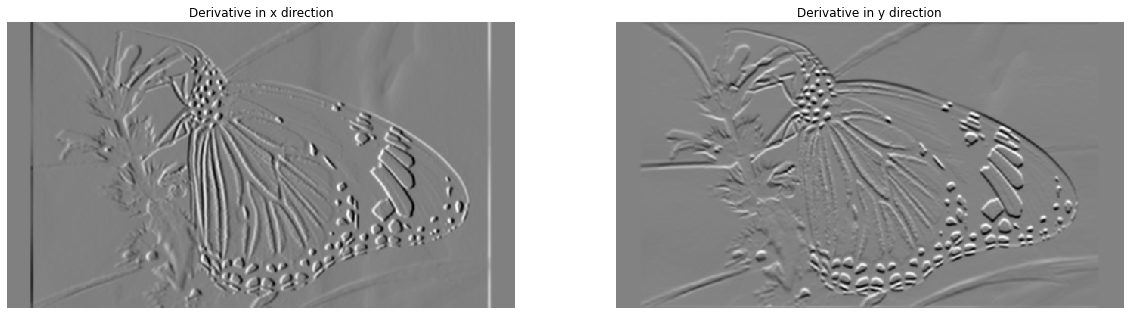

In [10]:
Gx = partial_x(smoothed)
Gy = partial_y(smoothed)

plt.subplot(1,2,1)
plt.imshow(Gx)
plt.title('Derivative in x direction')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(Gy)
plt.title('Derivative in y direction')
plt.axis('off')

plt.show()

#### Implementation
Now, we can compute the magnitude and direction of gradient with the two partial derivatives:

$$
G = \sqrt{G_{x}^{2}+G_{y}^{2}} \\
\Theta = arctan\bigl(\frac{G_{y}}{G_{x}}\bigr)
$$

Implement **`gradient`** which takes in an image and outputs $G$ and $\Theta$.

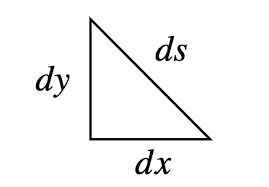

In [11]:
def gradient(img):
    G = np.zeros(img.shape)
    theta = np.zeros(img.shape)

    #code starts here
    dx = partial_x(img)
    dy = partial_y(img)
    G = np.sqrt(dx * dx + dy * dy) 
    theta = (np.arctan2(dy, dx) * 180 / np.pi) % 360
    #code ends here

    return G, theta

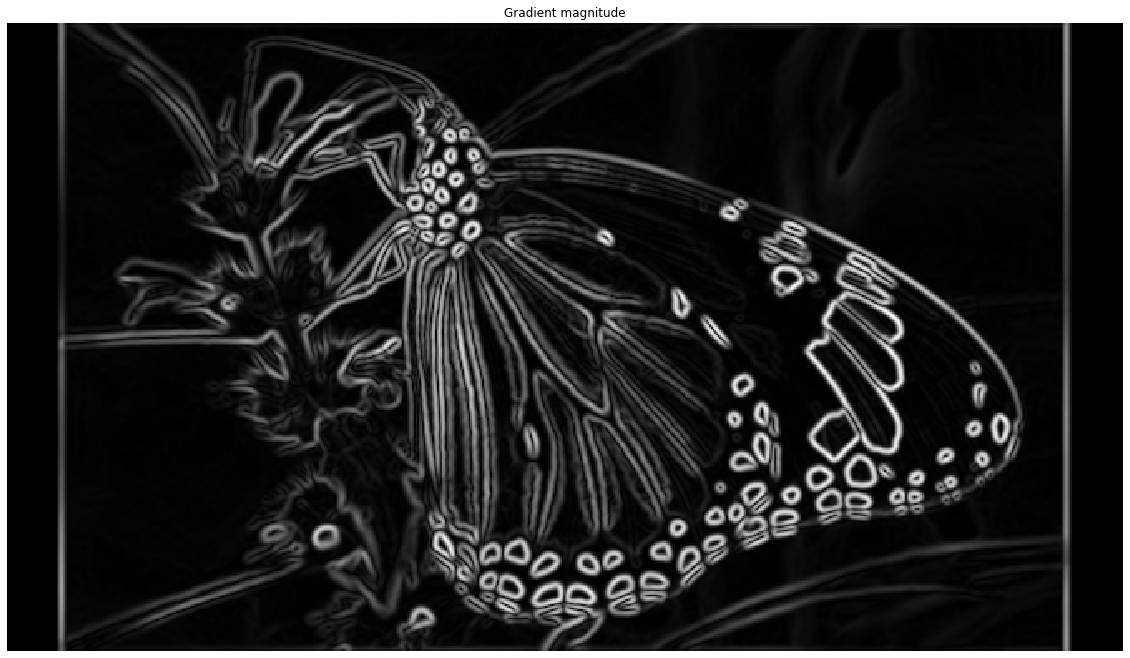

In [12]:
G, theta = gradient(smoothed)

if not np.all(G >= 0):
    print('Magnitude of gradients should be non-negative.')
    
if not np.all((theta >= 0) * (theta < 360)):
    print('Direction of gradients should be in range 0 <= theta < 360')

plt.imshow(G)
plt.title('Gradient magnitude')
plt.axis('off')
plt.show()

### 1.3 Non-maximum suppression
You should be able to see that the edges extracted from the gradient of the smoothed image are quite thick and blurry. The purpose of this step is to convert the "blurred" edges into "sharp" edges. Basically, this is done by preserving all local maxima in the gradient image and discarding everything else. The algorithm is for each pixel (x,y) in the gradient image:
1. Round the gradient direction $\Theta[y,x]$ to the nearest 45 degrees, corresponding to the use of an 8-connected neighbourhood.

2. Compare the edge strength of the current pixel with the edge strength of the pixel in the positive and negative gradient directions. For example, if the gradient direction is south (theta=90), compare with the pixels to the north and south.

3. If the edge strength of the current pixel is the largest; preserve the value of the edge strength. If not, suppress (i.e. remove) the value.

Implement **`non_maximum_suppression`**.

We provide the correct output and the difference between it and your result for debugging purposes.  If you see white spots in the Difference image, you should check your implementation.

In [13]:
def non_maximum_suppression(G, theta):
    H, W = G.shape
    out = np.zeros((H, W))

    # Round the gradient direction to the nearest 45 degrees
    theta = np.floor((theta + 22.5) / 45) * 45

    # ensure theta is in [0, 360]
    theta = theta % 360
    # use mask to keep strong edge pixels (i.e. greater than neighbours)
    mask = np.zeros((H, W), dtype=bool)

  #code starts here
    for m in range(1, H - 1):
        for n in range(1, W - 1):
            # Note: angle is measured clockwise
            if theta[m, n] == 0 or theta[m, n] == 180:
                mask[m, n] = G[m, n] >= np.max([G[m, n - 1], G[m, n + 1]])
            elif theta[m, n] == 45 or theta[m, n] == 225:
                mask[m, n] = G[m, n] >= np.max([G[m - 1, n - 1], G[m + 1, n + 1]])
            elif theta[m, n] == 90 or theta[m, n] == 270:
                mask[m, n] = G[m, n] >= np.max([G[m - 1, n], G[m + 1, n]])
            elif theta[m, n] == 135 or theta[m, n] == 315:
                mask[m, n] = G[m, n] >= np.max([G[m - 1, n + 1], G[m + 1, n - 1]])
            else:
                print("Wrong theta value " + str(theta[m, n]))

    out[mask] = G[mask]
    #code ends here
    return out

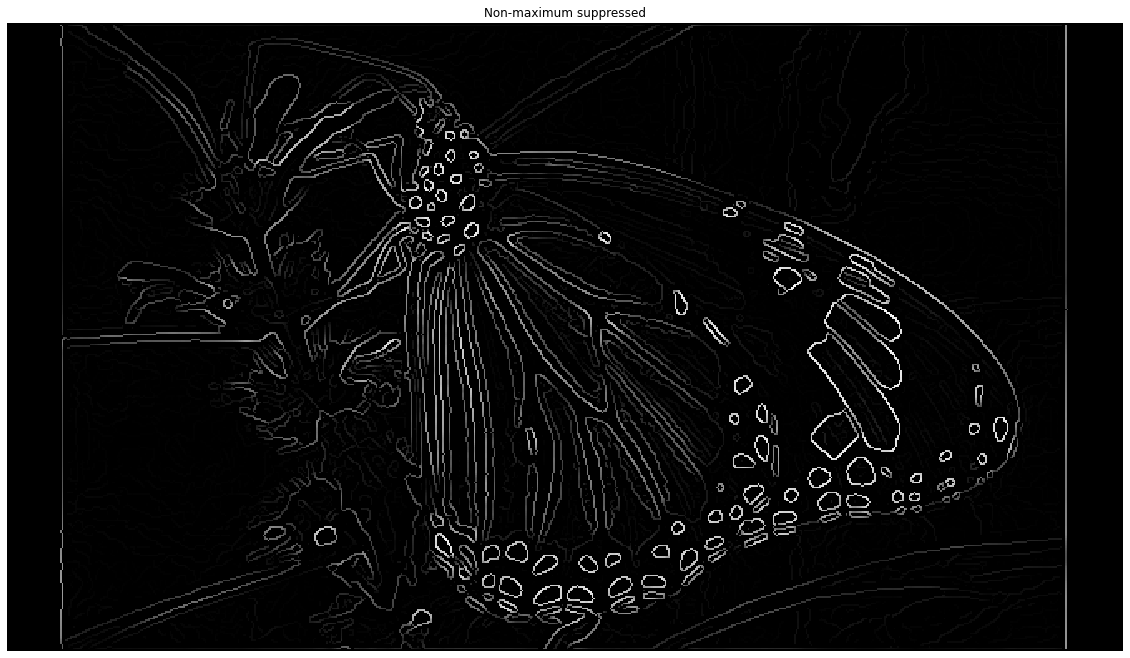

In [14]:
nms = non_maximum_suppression(G, theta)
plt.imshow(nms)
plt.title('Non-maximum suppressed')
plt.axis('off')
plt.show()

### 1.4 Double Thresholding

The edge-pixels remaining after the non-maximum suppression step are (still) marked with their strength pixel-by-pixel. Many of these will probably be true edges in the image, but some may be caused by noise or color variations, for instance, due to rough surfaces. The simplest way to discern between these would be to use a threshold, so that only edges stronger that a certain value would be preserved. The Canny edge detection algorithm uses double thresholding. Edge pixels stronger than the high threshold are marked as strong; edge pixels weaker than the low threshold are suppressed and edge pixels between the two thresholds are marked as weak.

Implement **`double_thresholding`**

In [15]:
def double_thresholding(img, high, low):
    strong_edges = np.zeros(img.shape, dtype=np.bool)
    weak_edges = np.zeros(img.shape, dtype=np.bool)

    #code starts here
    strong_edges[img >= high] = True
    weak_edges[(img >= low) & (img < high)] = True 
    #code ends here

    return strong_edges, weak_edges

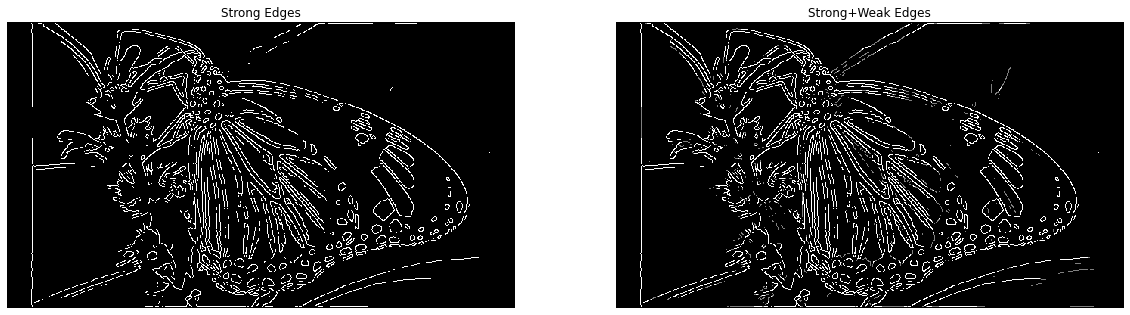

In [16]:
low_threshold = 0.02
high_threshold = 0.03

strong_edges, weak_edges = double_thresholding(nms, high_threshold, low_threshold)
assert(np.sum(strong_edges & weak_edges) == 0)

edges=strong_edges * 1.0 + weak_edges * 0.5

plt.subplot(1,2,1)
plt.imshow(strong_edges)
plt.title('Strong Edges')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(edges)
plt.title('Strong+Weak Edges')
plt.axis('off')

plt.show()

### 1.5 Edge tracking
Strong edges are interpreted as “certain edges”, and can immediately be included in the final edge image. Consider its neighbors iteratively then declare it an 'edge pixel' if it is connected to a 'strong edge pixel' directly or via pixels between Low and High. The logic is of course that noise and other small variations are unlikely to result in a strong edge (with proper adjustment of the threshold levels). Thus strong edges will (almost) only be due to true edges in the original image. The weak edges can either be due to true edges or noise/color variations. The latter type will probably be distributed independently of edges on the entire image, and thus only a small amount will be located adjacent to strong edges. Weak edges due to true edges are much more likely to be connected directly to strong edges.

Implement **`link_edges`**.

We provide the correct output and the difference between it and your result for debugging purposes.  If you see white spots in the Difference image, you should check your implementation.

In [17]:
def get_neighbors(y, x, H, W):
    neighbors = []

    for i in (y-1, y, y+1):
        for j in (x-1, x, x+1):
            if i >= 0 and i < H and j >= 0 and j < W:
                if (i == y and j == x):
                    continue
                neighbors.append((i, j))

    return neighbors

In [18]:
def link_edges(strong_edges, weak_edges):
    H, W = strong_edges.shape
    indices = np.stack(np.nonzero(strong_edges)).T
    edges = np.zeros((H, W), dtype=np.bool)

    # Make new instances of arguments to leave the original
    # references intact
    weak_edges = np.copy(weak_edges)
    edges = np.copy(strong_edges)

    #code starts here
    for m, n in indices:
        # for strong edges, check their neighbors and if those are weak edges
        # include them because they are connected to a strong edge
        # then do a breadth first search for other connected weak edges
        queue = get_neighbors(m, n, H, W)
        visited = []
        while queue:
            y, x = queue.pop(0)
            if (y, x) not in visited:
                visited.append((y,x))
                if weak_edges[y, x]:
                    edges[y, x] = True
                    queue.extend(get_neighbors(y, x, H, W))
    #code ends here

    return edges

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: edges_result.jpg is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  


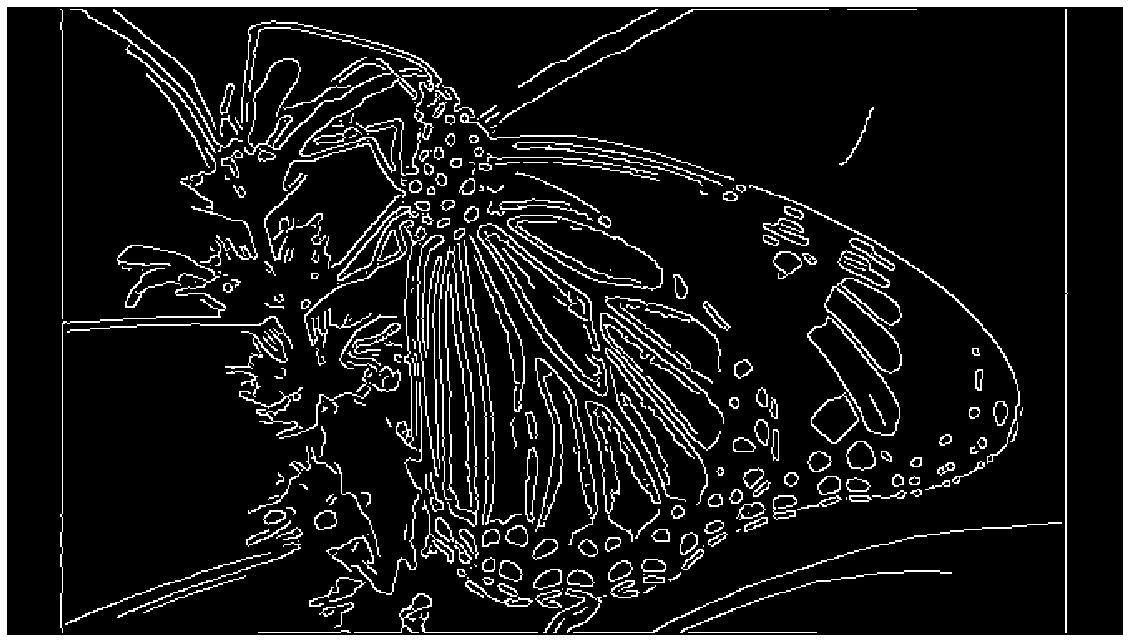

In [19]:
edges = link_edges(strong_edges, weak_edges)
io.imsave('edges_result.jpg',edges)
plt.imshow(edges)
plt.axis('off')
plt.show()

### Combining them all
#### Define Canny

In [20]:
def canny(img, kernel_size=5, sigma=1.4, high=20, low=15):

    #code starts here
    kernel = gaussian_kernel(kernel_size, sigma)
    smoothed = conv(img, kernel)
    G, theta = gradient(smoothed)
    nms = non_maximum_suppression(G, theta)
    strong_edges, weak_edges = double_thresholding(nms, high, low)
    edge = link_edges(strong_edges, weak_edges)
    #code ends here
    
    return edge

Text(0.5, 1.0, 'Reference')

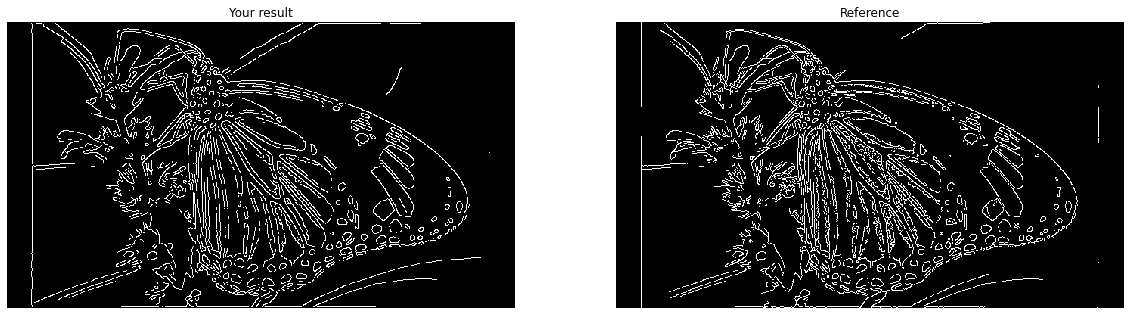

In [21]:
image = 'butterfly.jpeg'

# Load image and Run our code 
img = io.imread(image, as_gray=True)
edges = canny(img, kernel_size=5, sigma=1.4, high=0.03, low=0.02)

#make an OpenCV - Canny image 
import cv2 as cv
img=cv.imread(image,0)
canny_edges = cv.Canny(img,100,200)
canny_edges = cv.resize(canny_edges, (edges.shape[1],edges.shape[0]))


plt.subplot(1, 2, 1)
plt.imshow(edges)
plt.axis('off')
plt.title('Your result')

plt.subplot(1, 2, 2)
# reference = np.load('')
plt.imshow(canny_edges)
plt.axis('off')
plt.title('Reference')
